# Try running a single ML model

In [1]:
import argparse
import logging
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("../..")

In [4]:
feature_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/new_baseline/processed_data/x-all.pkl"
response_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/amg-232_2.5.csv"
output_dir = "nn_test"

In [5]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

In [6]:
# load data
logger.info("Loading feature data...")
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
feature_df.set_index("ccle_name", inplace=True)
feature_df.fillna(-1, inplace=True)

INFO:__main__:Loading feature data...


In [7]:
logger.info("Loading response data...")
response_df = pd.read_csv(response_path)

# only keep cell lines we have features for
available_ccle_names = set(feature_df.index)
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

# drop culture column
response_df = response_df.drop(columns=["culture"])
# drop duplicates by ccle_name, keep first
response_df = response_df.drop_duplicates(subset=["ccle_name"], keep="first")

INFO:__main__:Loading response data...


In [8]:
from refract.trainers import *
from sklearn.preprocessing import StandardScaler

In [9]:
# train test val split on response_df ccle_names
train_ccle_names, test_ccle_names = train_test_split(response_df["ccle_name"], test_size=0.2, random_state=42)
train_ccle_names, val_ccle_names = train_test_split(train_ccle_names, test_size=0.2, random_state=42)

# get response_train, response_val, response_test dfs in order 
response_train_df = response_df.loc[response_df.ccle_name.isin(train_ccle_names)]
response_val_df = response_df.loc[response_df.ccle_name.isin(val_ccle_names)]
response_test_df = response_df.loc[response_df.ccle_name.isin(test_ccle_names)]

# drop all columns with zero stddev
feature_df = feature_df.loc[:, feature_df.std() != 0]

X_train_df = feature_df.loc[response_train_df.ccle_name.values, :]
X_val_df = feature_df.loc[response_val_df.ccle_name.values, :]
X_test_df = feature_df.loc[response_test_df.ccle_name.values, :]

top_features = get_n_correlated_features(
    response_train_df['LFC.cb'].values,
    X_train_df.values,
    X_train_df.columns,
    n=500
)

/home/groups/corsello/nphill22/tools/miniconda3/envs/lab/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/groups/corsello/nphill22/tools/miniconda3/envs/lab/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Load all the responses for all compounds

In [10]:
import glob
import tqdm

In [11]:
response_files = glob.glob("/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/*.csv")

In [12]:
all_responses = []
for response_path in tqdm.tqdm(response_files):
    response_df = pd.read_csv(response_path)
    df = response_df.loc[:, ["ccle_name", "pert_name", "pert_idose", "LFC.cb"]]
    # concatenate pert_name and pert_idose
    df["pert_name"] = df["pert_name"] + "_" + df["pert_idose"].astype(str)
    df = df.drop(columns=["pert_idose"])
    all_responses.append(df)
response_df = pd.concat(all_responses, axis=0)

100%|██████████| 6513/6513 [00:22<00:00, 292.85it/s]


In [13]:
response_df.head()

,ccle_name,pert_name,LFC.cb
0,NIHOVCAR3_OVARY,micafungin_2.5,-0.079331
1,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,micafungin_2.5,0.753126
2,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,micafungin_2.5,-0.038481
3,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,micafungin_2.5,-0.125686
4,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,micafungin_2.5,1.384392


In [14]:
feature_df.head()

,GE_TSPAN6,GE_TNMD,GE_DPM1,GE_SCYL3,GE_C1orf112,GE_FGR,GE_CFH,GE_FUCA2,GE_GCLC,GE_NFYA,...,MET_C56:8 TAG,MET_C56:7 TAG,MET_C56:6 TAG,MET_C56:5 TAG,MET_C56:4 TAG,MET_C56:3 TAG,MET_C56:2 TAG,MET_C58:8 TAG,MET_C58:7 TAG,MET_C58:6 TAG
ccle_name,,,,,,,,,,,,,,,,,,,,,
127399_SOFT_TISSUE,3.243364,0.000000,6.863567,2.063503,3.916477,0.070389,0.056584,5.426600,3.820690,2.976364,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1321N1_CENTRAL_NERVOUS_SYSTEM,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
143B_BONE,4.719731,0.000000,7.360540,1.778209,3.786596,0.014355,0.713696,5.393348,4.638074,3.046142,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
170MGBA_CENTRAL_NERVOUS_SYSTEM,4.155425,0.124328,6.681590,2.430285,2.799087,0.815575,3.559492,7.252855,4.300856,3.682573,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
184A1_BREAST,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Code for model componenets

In [15]:
# now, make a dataset to return the data in expected format
from sklearn.preprocessing import LabelEncoder

class PrismDataset(torch.utils.data.Dataset):
    def __init__(self, feature_df, response_df, drug_name_encoder, \
            cell_line_col="ccle_name", response_col="LFC.cb", drug_col="pert_name"):
        self.feature_df = feature_df
        self.response_df = response_df
        self.cell_line_col = cell_line_col
        self.response_col = response_col
        self.drug_col = drug_col

        self.drug_names = self.response_df[self.drug_col].values
        # encode drug names as integers
        self.drug_name_encoder = drug_name_encoder
        self.drug_names = self.drug_name_encoder.transform(self.drug_names)
        self.cell_lines = self.response_df[self.cell_line_col].values
        self.responses = self.response_df[self.response_col].values
        self.num_embeddings = len(self.drug_name_encoder.classes_)

    def __len__(self):
        return len(self.responses)

    def __getitem__(self, idx):
        response = self.responses[idx]
        drug = self.drug_names[idx]
        cell_line = self.cell_lines[idx]
        features = self.feature_df.loc[cell_line, :].values

        # return all as tensors
        response = torch.tensor(response, dtype=torch.float32)
        drug = torch.tensor(drug, dtype=torch.long)
        features = torch.tensor(features, dtype=torch.float32)

        return features, drug, response

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_model(input_dim, num_embeddings, embedding_dim, dropout_rate=0.5):
    # Define a simple feedforward neural network structure with an embedding layer, dropout, and batch normalization
    class FeedforwardNeuralNetwork(nn.Module):
        def __init__(self, input_dim, num_embeddings, embedding_dim, dropout_rate):
            super(FeedforwardNeuralNetwork, self).__init__()
            # Define an embedding layer for perturbation names
            self.embedding = nn.Embedding(num_embeddings, embedding_dim)
            # Define three hidden layers and output layer
            self.fc1 = nn.Linear(input_dim + embedding_dim, 128)  # First hidden layer, adjusted for embedding
            self.fc2 = nn.Linear(128, 64)                        # Second hidden layer
            self.fc3 = nn.Linear(64, 32)                         # Third hidden layer
            self.fc4 = nn.Linear(32, 1)                          # Output layer
            # Dropout layers
            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)
            self.dropout3 = nn.Dropout(dropout_rate)
            # Batch normalization layers
            self.bn1 = nn.BatchNorm1d(128)
            self.bn2 = nn.BatchNorm1d(64)
            self.bn3 = nn.BatchNorm1d(32)

        def forward(self, x, pert_name):
            x = x.float()
            # Embedding for the perturbation name
            pert_embedding = self.embedding(pert_name).float()
            # Concatenate the embedding with the input features
            x = torch.cat([x, pert_embedding], dim=1)
            # Activation functions, batch normalization, and dropout for the hidden layers
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = F.relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.fc4(x)  # No activation for output layer, assuming regression task
            return x

    # Create the neural network model
    model = FeedforwardNeuralNetwork(input_dim, num_embeddings, embedding_dim, dropout_rate)
    return model


In [17]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

def save_checkpoint(model, optimizer, epoch, loss, filename="model_checkpoint_{}.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename.format(epoch))

def train_model(model, train_dataloader, val_dataloader, num_epochs, patience):
    # Assuming the loss function and optimizer are predefined globally or are parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    # Initialize TensorBoard writer
    writer = SummaryWriter()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for inputs, cell_line, targets in tqdm.tqdm(train_dataloader):
            inputs, cell_line, targets = inputs.to(device), cell_line.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs, cell_line).squeeze().float()
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataloader.dataset)

        # Log training loss
        writer.add_scalar('Loss/Train', train_loss, epoch)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, cell_line, targets in val_dataloader:
                inputs, cell_line, targets = inputs.to(device), cell_line.to(device), targets.to(device)
                outputs = model(inputs, cell_line).squeeze().float()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)

        # Log validation loss
        writer.add_scalar('Loss/Validation', val_loss, epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        save_checkpoint(model, optimizer, epoch, loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Close the writer
    writer.close()

    # Load the best model back
    model.load_state_dict(torch.load('best_model.pth'))

# Example call to the training function:
# train_model(model, train_loader, val_loader, num_epochs=50, patience=5)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

# Dataset Prep

In [20]:
# only keep responses we have features for
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

In [21]:
# split the responses by train, val, test on ccle_name
response_train = response_df[response_df["ccle_name"].isin(train_ccle_names)]
response_val = response_df[response_df["ccle_name"].isin(val_ccle_names)]
response_test = response_df[response_df["ccle_name"].isin(test_ccle_names)]

# filter X_train, X_val, X_test to only top features
#X_train = X_train_df.loc[:, top_features]
#X_val = X_val_df.loc[:, top_features]
#X_test = X_test_df.loc[:, top_features]

X_train = X_train_df.copy()
X_val = X_val_df.copy()
X_test = X_test_df.copy()


In [22]:
# standard scale the features, return dataframes
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [23]:
drug_encoder = LabelEncoder()
drugs = response_df.pert_name.unique()
drug_encoder = drug_encoder.fit(drugs)

In [24]:
import pickle
with open('drug_encoder.pkl', 'wb') as f:
    pickle.dump(drug_encoder, f)

In [25]:
# create the datasets
train_dataset = PrismDataset(X_train, response_train, drug_encoder)
val_dataset = PrismDataset(X_val, response_val, drug_encoder)
test_dataset = PrismDataset(X_test, response_test, drug_encoder)

In [26]:
# Create dataloaders for training and test
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=24)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=24)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=24)

In [27]:
# get the model 
model = get_model(input_dim=X_train.shape[1], num_embeddings=train_dataset.num_embeddings, embedding_dim=10)

In [28]:
model

FeedforwardNeuralNetwork(
  (embedding): Embedding(6513, 10)
  (fc1): Linear(in_features=110145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [29]:
train_model(model, train_dl, val_dl, num_epochs=200, patience=10)

100%|██████████| 2276/2276 [08:16<00:00,  4.58it/s]


Epoch [1/200], Train Loss: 1.1800, Val Loss: 1.1725


100%|██████████| 2276/2276 [08:37<00:00,  4.40it/s]


Epoch [2/200], Train Loss: 0.9632, Val Loss: 0.5713


100%|██████████| 2276/2276 [08:28<00:00,  4.48it/s]


Epoch [3/200], Train Loss: 0.6084, Val Loss: 0.4897


100%|██████████| 2276/2276 [08:30<00:00,  4.46it/s]


Epoch [4/200], Train Loss: 0.5403, Val Loss: 0.4697


100%|██████████| 2276/2276 [09:17<00:00,  4.08it/s]  


Epoch [5/200], Train Loss: 0.5112, Val Loss: 0.4873


100%|██████████| 2276/2276 [08:31<00:00,  4.45it/s]


Epoch [6/200], Train Loss: 0.4905, Val Loss: 0.4548


100%|██████████| 2276/2276 [08:27<00:00,  4.48it/s]


Epoch [7/200], Train Loss: 0.4795, Val Loss: 0.5307


100%|██████████| 2276/2276 [08:37<00:00,  4.40it/s]


Epoch [8/200], Train Loss: 0.4678, Val Loss: 0.5303


100%|██████████| 2276/2276 [08:32<00:00,  4.45it/s]


Epoch [9/200], Train Loss: 0.4603, Val Loss: 0.4747


100%|██████████| 2276/2276 [08:41<00:00,  4.37it/s]  


Epoch [10/200], Train Loss: 0.4555, Val Loss: 0.4560


100%|██████████| 2276/2276 [08:27<00:00,  4.48it/s]


Epoch [11/200], Train Loss: 0.4492, Val Loss: 0.4372


100%|██████████| 2276/2276 [08:31<00:00,  4.45it/s]


Epoch [12/200], Train Loss: 0.4450, Val Loss: 0.4842


100%|██████████| 2276/2276 [08:27<00:00,  4.49it/s]


Epoch [13/200], Train Loss: 0.4411, Val Loss: 0.4402


100%|██████████| 2276/2276 [08:23<00:00,  4.52it/s]


Epoch [14/200], Train Loss: 0.4396, Val Loss: 0.4161


100%|██████████| 2276/2276 [08:25<00:00,  4.51it/s]


Epoch [15/200], Train Loss: 0.4370, Val Loss: 0.4180


100%|██████████| 2276/2276 [08:30<00:00,  4.45it/s]


In [ ]:
# checkpoint model to disk
#checkpoint = {
#    "model_state_dict": model.state_dict()
#}
#torch.save(checkpoint, "initial_model_full_train.pth")

In [ ]:
#state_dict = torch.load('best_model.pth', map_location=torch.device('cpu'))
#model.load_state_dict(state_dict)

In [ ]:
model = model.to('cpu')

In [ ]:
out = []

for f, d, l in tqdm.tqdm(test_dataset):
    # drug 
    drug_name = train_dataset.drug_name_encoder.inverse_transform([d.detach().numpy()])
    p = model(f.unsqueeze(0), d.unsqueeze(0))
    out.append({"drug_name": drug_name, "true": l.detach().numpy(), "pred": p.detach().numpy()})

 52%|█████▏    | 393489/753472 [22:44<20:48, 288.36it/s]  


KeyboardInterrupt: 

In [ ]:
train_results_df = pd.DataFrame(out)

In [ ]:
train_results_df.drug_name = [i[0] for i in train_results_df.drug_name.values]

In [ ]:
train_results_df.pred = [i[0][0] for i in train_results_df.pred.values]

In [ ]:
# choose compound amg-232
tmp = train_results_df.loc[train_results_df.drug_name == "amg-232_2.5", :]

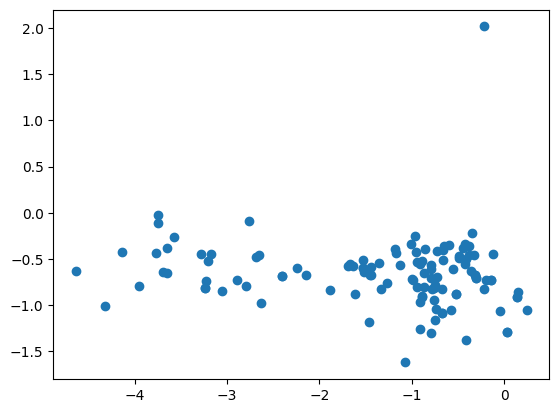

In [ ]:
plt.scatter(tmp.true, tmp.pred)

In [ ]:
train_results_df.to_csv("init_train_results.csv")

In [ ]:
#train_results_df

In [ ]:
response_train.to_csv("response_train.csv")
response_test.to_csv("response_test.csv")